In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G
from astropy.constants import c
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd

## Initial condition

In [ ]:
Msun = (1 * u.Msun).si.value
m_1 = 10 * Msun
m_2 = 4.3e6 * Msun
m_bh = 10 * Msun
G = G.si.value
pc= (1*u.pc).si.value
c = c.si.value

## Time derivative of a and e

In [ ]:
def da_dt_gw(a, e):

    mu = m_1 * m_2 / (m_1 + m_2)  
    M = m_1 + m_2  

    factor1 = - (64 / 5) * (G**3 * mu * M**2) / (c**5 * a**3)
    factor2 = 1 / (1 - e**2)**(7/2)
    factor3 = 1 + (73/24) * e**2 + (37/96) * e**4
    return factor1 * factor2 * factor3

def de_dt_gw(a, e):

    mu = m_1 * m_2 / (m_1 + m_2)  
    M = m_1 + m_2  
    
    factor1 = - (304 / 15) * (G**3 * mu * M**2) / (c**5 * a**4)
    factor2 = e / (1 - e**2)**(5/2)
    factor3 = 1 + (121/304) * e**2
    return factor1 * factor2 * factor3


## Characteristic time

In [ ]:

def tgw(a,e):

    return (1 - e) / np.abs(de_dt_gw(a , e))


def trlx(a,e):

    r0 = 1 * pc 
    n0 = 2e4

    t0 = 4.26/(3**(3/2)) * np.sqrt(r0**3 * (G * m_2)**(-1)) / (n0 * np.log(m_2/m_bh))\
        * (m_2/m_bh)**2
    
    return t0 * (a / r0)**(1/2) * (1-e)

def a_from_second_equation(e):

    w = 0.26
    return  w * 8 * G * m_2 / (c**2 * (1 - e))

def eq1(a,e):
   
    return tgw(a,e) - trlx(a,e) 

## Formation calculation

In [8]:
one_minus_e_values = np.logspace(-6.5, -0.1, 200)
e_values = 1 - one_minus_e_values
a_initial_guess = 1 * pc
a_values_1 = a_from_second_equation(e_values)
a_values_2 = [fsolve(lambda a: eq1(a, e), a_initial_guess)[0]  for e in e_values]

In [ ]:

f1 = interp1d(e_values, a_values_1, kind='linear', fill_value="extrapolate")
f2 = interp1d(e_values, a_values_2, kind='linear', fill_value="extrapolate")
f3 = interp1d(a_values_2,e_values, kind='linear', fill_value="extrapolate")

def diff(e):
    return f1(e) - f2(e)


e_min, e_max = 1, 0
try:
    intersection_e = brentq(diff, e_min, e_max)
    intersection_a = f1(intersection_e)

    print(f"交点：e = {intersection_e}, a = {intersection_a/pc}pc")

except ValueError:
    print("没有找到交点，可能是因为曲线没有交汇点或需要更大的区间。")

交点：e = 0.9999996073955106, a = 1.090621649026597pc


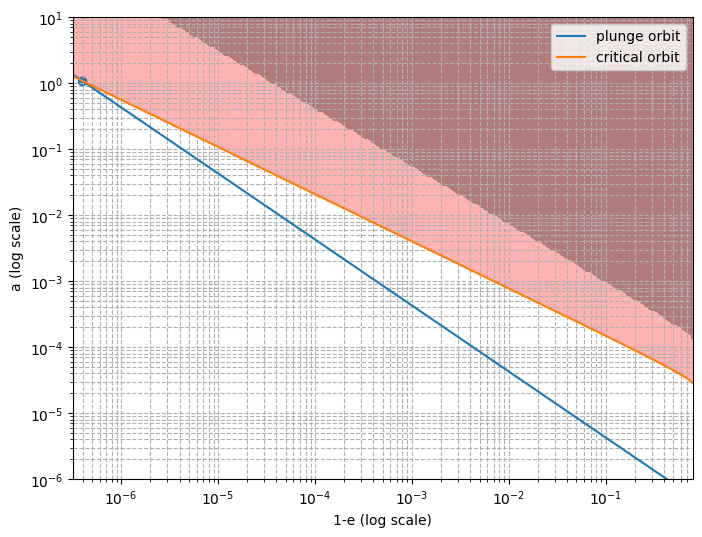

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(one_minus_e_values, a_values_1/pc, label="plunge orbit")
plt.plot(one_minus_e_values, a_values_2/pc, label="critical orbit")

A = np.logspace(-6, 1, 200) * pc
ONE_MINUS_E = np.logspace(-6.5, -0.1, 200)
A, ONE_MINUS_E = np.meshgrid(A, ONE_MINUS_E)
E = 1 - ONE_MINUS_E
trlx_values = trlx(A, E)
tgw_values = tgw(A, E)
condition1 = trlx_values < tgw_values
condition2 = 1e10 * 365 * 24 * 60 * 60 < tgw_values
plt.contourf(
    ONE_MINUS_E,
    A / pc,
    condition1,
    levels=[0.5, 1],
    colors=['red'],
    alpha=0.3,
    linestyles=None
)

plt.contourf(
    ONE_MINUS_E,
    A / pc,
    condition2,
    levels=[0.5, 1],
    colors=['black'],
    alpha=0.3,
    linestyles=None
)

plt.scatter(1-intersection_e,intersection_a/pc)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("1-e (log scale)")
plt.ylabel("a (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:

emri_form_gw = pd.DataFrame({
        '1-e':one_minus_e_values,
        'a_losscone':a_values_1/pc,
        'a_decay_dominate':a_values_2/pc
})

emri_form_gw.to_csv('data/10emri_form_gw0.26.csv',index=False)